# ==========================================
# 1. Imports & Configuration
# ==========================================

In [1]:
from __future__ import annotations

import os
import pickle
from pathlib import Path
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# --- Configuration ---

In [2]:
PROJECT_ROOT = Path("..")  # notebooks/ -> project root
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
FIGURES_DIR = PROJECT_ROOT / "results" / "figures"

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)


def save_plot(filename: str) -> None:
    path = FIGURES_DIR / f"{filename}.png"
    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print(f"[+] Plot saved: {path}")


def load_cleaned_data(processed_dir: Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    train_path = processed_dir / "train_cleaned.csv"
    test_path = processed_dir / "test_cleaned.csv"

    if not train_path.exists() or not test_path.exists():
        raise FileNotFoundError(
            f"Missing cleaned files.\n"
            f"Expected:\n - {train_path}\n - {test_path}\n"
            f"Run 01_data_exploration.ipynb first (and make sure it saved to data/processed/)."
        )

    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    print(f"[+] Loaded Train: {train_df.shape} from {train_path}")
    print(f"[+] Loaded Test : {test_df.shape} from {test_path}")

    return train_df, test_df


# ==========================================
# 2. Load Cleaned Data
# ==========================================

In [3]:
print("[1] Loading cleaned datasets...")
train_df, test_df = load_cleaned_data(PROCESSED_DIR)

required_label_col = "label"
if required_label_col not in train_df.columns or required_label_col not in test_df.columns:
    raise ValueError("Expected a 'label' column in both train and test cleaned CSVs.")


[1] Loading cleaned datasets...
[+] Loaded Train: (125973, 44) from ..\data\processed\train_cleaned.csv
[+] Loaded Test : (22544, 42) from ..\data\processed\test_cleaned.csv


# ==========================================
# 3. Label Engineering (Target Variable)
# ==========================================

# We need to prepare two types of labels:
# 1. Binary: Normal vs Attack
# 2. Multi-class: Normal, DoS, Probe, R2L, U2R

In [4]:
print("\n[2] Processing Labels (Targets)...")


[2] Processing Labels (Targets)...


# --- Define Attack Mapping (NSL-KDD Standard) ---

# Maps specific attacks to 4 main categories

In [5]:

attack_mapping = {
    "normal": "Normal",

    # DoS
    "back": "DoS", "land": "DoS", "neptune": "DoS", "pod": "DoS", "smurf": "DoS",
    "teardrop": "DoS", "mailbomb": "DoS", "apache2": "DoS", "processtable": "DoS",
    "udpstorm": "DoS", 'worm': 'DoS',

    # Probe
    "satan": "Probe", "ipsweep": "Probe", "nmap": "Probe", "portsweep": "Probe",
    "mscan": "Probe", "saint": "Probe",

    # R2L
    "guess_passwd": "R2L", "ftp_write": "R2L", "imap": "R2L", "phf": "R2L",
    "multihop": "R2L", "warezmaster": "R2L", "warezclient": "R2L", "spy": "R2L",
    "xlock": "R2L", "xsnoop": "R2L", "snmpguess": "R2L", "snmpgetattack": "R2L",
    "httptunnel": "R2L", "sendmail": "R2L", "named": "R2L",

    # U2R
    "buffer_overflow": "U2R", "loadmodule": "U2R", "perl": "U2R", "rootkit": "U2R",
    "ps": "U2R", "sqlattack": "U2R", "xterm": "U2R",
}

# Map to coarse categories; keep Unknown explicitly (useful for analysis)
train_df["attack_category"] = train_df["label"].map(attack_mapping).fillna("Unknown")
test_df["attack_category"] = test_df["label"].map(attack_mapping).fillna("Unknown")

print("Train attack_category distribution:")
print(train_df["attack_category"].value_counts(), "\n")

print("Test attack_category distribution (including Unknown):")
print(test_df["attack_category"].value_counts())

# Binary target: Normal=0, everything else=1 (including Unknown)
y_train_binary = (train_df["attack_category"] != "Normal").astype(int).to_numpy()
y_test_binary = (test_df["attack_category"] != "Normal").astype(int).to_numpy()

# Multi-class target (encoded). Note: Includes Unknown as a class if present.
le = LabelEncoder()
le.fit(pd.concat([train_df["attack_category"], test_df["attack_category"]], axis=0))

y_train_multi = le.transform(train_df["attack_category"])
y_test_multi = le.transform(test_df["attack_category"])

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"\n[+] Multi-class mapping: {label_mapping}")

# Features: drop raw label + engineered category
X_train_raw = train_df.drop(columns=["label", "attack_category"])
X_test_raw = test_df.drop(columns=["label", "attack_category"])

X_test_raw = X_test_raw.reindex(columns=X_train_raw.columns, fill_value=0)



Train attack_category distribution:
attack_category
Normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64 

Test attack_category distribution (including Unknown):
attack_category
Normal    9711
DoS       7460
R2L       2885
Probe     2421
U2R         67
Name: count, dtype: int64

[+] Multi-class mapping: {'DoS': np.int64(0), 'Normal': np.int64(1), 'Probe': np.int64(2), 'R2L': np.int64(3), 'U2R': np.int64(4)}


# ==========================================
# 4. Feature Engineering & Preprocessing Pipeline
# ==========================================

In [6]:
print("\n[3] Building Preprocessing Pipeline...")

# --- Drop Zero Variance Columns (based on Train only) ---
numeric_cols_temp = X_train_raw.select_dtypes(include=[np.number]).columns

# Robust: nunique <= 1 is safer than std == 0
zero_variance_cols = [col for col in numeric_cols_temp if X_train_raw[col].nunique(dropna=False) <= 1]

if zero_variance_cols:
    print(f"[!] Dropping zero-variance columns (train-based): {zero_variance_cols}")
    X_train_raw = X_train_raw.drop(columns=zero_variance_cols)
    X_test_raw  = X_test_raw.drop(columns=zero_variance_cols, errors="ignore")
# -----------------------------------------

expected_categorical = ["protocol_type", "service", "flag"]
categorical_features = [c for c in expected_categorical if c in X_train_raw.columns]

missing_cat = set(expected_categorical) - set(categorical_features)
if missing_cat:
    print(f"[!] Warning: Missing categorical columns in train: {sorted(missing_cat)}")
    print("    Will proceed with existing categorical columns only.")

# Numeric columns: take all numeric types EXCEPT categoricals (categoricals are objects anyway, but keep safe)
numeric_features = (
    X_train_raw
    .drop(columns=categorical_features, errors="ignore")
    .select_dtypes(include=[np.number])
    .columns
    .tolist()
)

print(f"Numerical features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Handle sklearn version differences:
# - older sklearn: OneHotEncoder(sparse=False)
# - newer sklearn: OneHotEncoder(sparse_output=False)
def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", make_ohe(), categorical_features),
    ],
    remainder="drop",
)

print("[*] Fitting preprocessor on train and transforming train/test...")
X_train_processed = preprocessor.fit_transform(X_train_raw)
X_test_processed = preprocessor.transform(X_test_raw)

print(f"[+] X_train_processed shape: {X_train_processed.shape}")
print(f"[+] X_test_processed  shape: {X_test_processed.shape}")

# Extract feature names (optional but useful)
feature_names = None
try:
    num_names = np.array(numeric_features, dtype=object)
    cat_encoder = preprocessor.named_transformers_["cat"]
    cat_names = cat_encoder.get_feature_names_out(categorical_features)
    feature_names = np.r_[num_names, cat_names]
    print(f"[+] Feature names extracted: {len(feature_names)}")
except Exception as e:
    print(f"[!] Could not extract feature names (ok to continue). Reason: {e}")



[3] Building Preprocessing Pipeline...
[!] Dropping zero-variance columns (train-based): ['num_outbound_cmds']
Numerical features: 38
Categorical features: 3
[*] Fitting preprocessor on train and transforming train/test...
[+] X_train_processed shape: (125973, 122)
[+] X_test_processed  shape: (22544, 122)
[+] Feature names extracted: 122


# ==========================================
# 5. Validation & Visualization
# ==========================================


[4] Plotting class balance (Binary)...
[+] Plot saved: ..\results\figures\split_distribution_binary.png


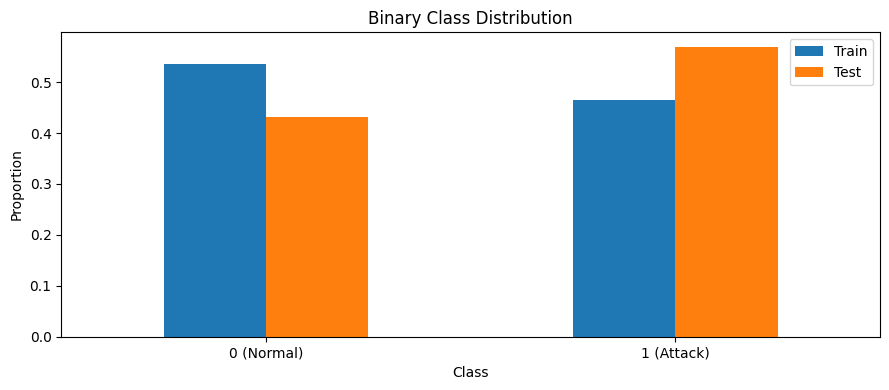

In [7]:
print("\n[4] Plotting class balance (Binary)...")

def plot_class_balance_binary(y_tr: np.ndarray, y_te: np.ndarray) -> None:
    tr = pd.Series(y_tr).value_counts(normalize=True).sort_index()
    te = pd.Series(y_te).value_counts(normalize=True).sort_index()
    dist = pd.DataFrame({"Train": tr, "Test": te}).fillna(0.0)

    ax = dist.plot(kind="bar", figsize=(9, 4))
    ax.set_title("Binary Class Distribution")
    ax.set_xlabel("Class")
    ax.set_ylabel("Proportion")
    ax.set_xticklabels(["0 (Normal)", "1 (Attack)"], rotation=0)

    save_plot("split_distribution_binary")
    plt.show()

plot_class_balance_binary(y_train_binary, y_test_binary)

# ==========================================
# 6. Save Artifacts
# ==========================================

In [8]:
print("\n[5] Saving artifacts...")

np.save(PROCESSED_DIR / "X_train.npy", X_train_processed)
np.save(PROCESSED_DIR / "X_test.npy", X_test_processed)
np.save(PROCESSED_DIR / "y_train_binary.npy", y_train_binary)
np.save(PROCESSED_DIR / "y_test_binary.npy", y_test_binary)
np.save(PROCESSED_DIR / "y_train_multi.npy", y_train_multi)
np.save(PROCESSED_DIR / "y_test_multi.npy", y_test_multi)

if feature_names is not None:
    pd.DataFrame({"feature": feature_names}).to_csv(PROCESSED_DIR / "feature_names.csv", index=False)

with open(PROCESSED_DIR / "preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f)

with open(PROCESSED_DIR / "label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print(f"[+] Done. Saved arrays + preprocessor to: {PROCESSED_DIR}")
print(f"[+] Figures saved to: {FIGURES_DIR}")


[5] Saving artifacts...
[+] Done. Saved arrays + preprocessor to: ..\data\processed
[+] Figures saved to: ..\results\figures
